MLPR Lab 1
By Ersaaj Sarkar Gupta
U20240040

Report attached at the end

# Introduction

In [1]:
# ----- Install Libraries ----- #
!pip install opencv-python
!pip install numpy
!pip install matplotlib

In [2]:
# ---- Imports ---- #

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

Image imported as <class 'numpy.ndarray'>


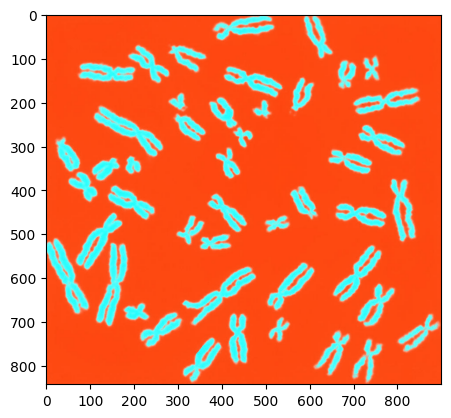

In [ ]:
# ---- Read Image ---- #

image_path : Path = Path("chromosomes.jpg")
image = cv2.imread(image_path) # <--- This is a stupid error, imread expects a str for a path (non fatal error)

print(f"Image imported as {type(image)}")
# Display image
plt.imshow(image)

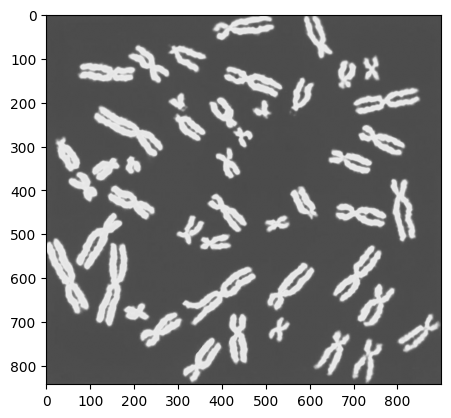

In [4]:
# ---- Convert Image to Greyscale ---- #

grayscale_image : np.ndarray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display image
plt.imshow(grayscale_image, cmap='gray', vmin=0, vmax=255)

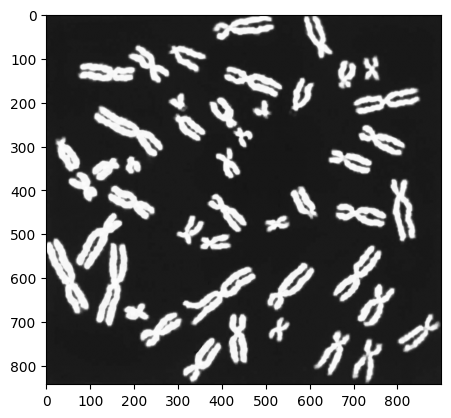

In [ ]:
# ---- Morphological Opening for Background Removal ---- #

# Define kernel
kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT, # Select shape
    (5,5), # Select k-size
    anchor=None
)

"""
Notes for Reference:
    Erosion: 
        A pixel stays white only if the kernel fits fully in the white
        region.

        White blobs shrink, thin lines break and small white noise disappears.

    Dialtion:
        A pixel becomes white if any part of the kernel touches white.

        White blobs grow, gaps between white regions may connect and holes get smaller
        (since white expands into them).

    Opening: Erosion, followed by dialation
        Removes all small, white noise. Large shapes remain mostly intact and boundaries
        are smooothened.

    Closing: Dialation, followed by erosion.
"""

# Morphological operation -- Opening
image_open = cv2.morphologyEx(grayscale_image, cv2.MORPH_OPEN, kernel)

# Display
plt.imshow(image_open, cmap="gray")

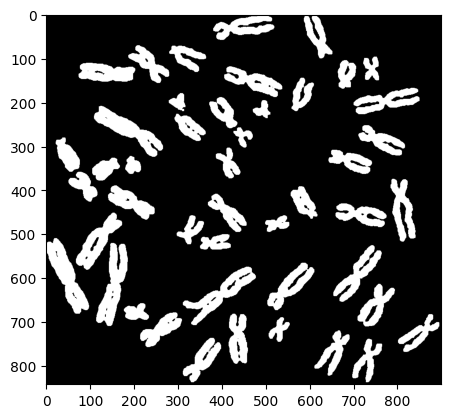

In [ ]:
# ---- Image Thresholding ---- #

_, thresh_image = cv2.threshold(
    image_open,
    127, # Threshold
    255, # Maxval
    cv2.THRESH_BINARY, # Threshold type
)

# Display
plt.imshow(thresh_image, cmap='gray')

In [ ]:
#  ---- Find Contours ---- #

contours, hierarchy = cv2.findContours(
    thresh_image,
    cv2.RETR_EXTERNAL, # Outermost contours, ignore holes (Contour Mode)
    cv2.CHAIN_APPROX_SIMPLE, # Stores corner pixels, uses less space (Contour method)
)

print(f"Number of contours extracted: {len(contours)}")

if len(contours) < 5 :
    raise Exception("Too few contours!")

# Store features for each chromosome
features : list = list([])

# Loop through all the contours
for i,c in enumerate(contours):
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    circularity = (4 * np.pi * area) /  (perimeter**2)

    x,y,w,h = cv2.boundingRect(c) # Bounding box

    features.append(dict({
        'id': i,
        'x': x, 'y': y,
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'width': w,
        'height': h,
        'aspect_ratio' : h / w # Shape
    }))


# ---- Place Features into a Dataframe ---- #

import pandas as pd

df : pd.DataFrame = pd.DataFrame(features)
print(df)

# Does anyone even read these comments?

Number of contours extracted: 46
    id    x    y    area   perimeter  circularity  width  height  aspect_ratio
0    0  696  739  2488.5  412.634556     0.183661     68      99      1.455882
1    1  311  737  3492.5  385.404108     0.295470     87     101      1.160920
2    2  610  720  2818.0  437.102592     0.185346     80     103      1.287500
3    3  506  690  1163.0  214.166520     0.318630     48      56      1.166667
4    4  800  683  2588.5  441.144223     0.167146     94      86      0.914894
5    5  415  682  3674.5  370.007140     0.337278     44     114      2.590909
6    6  214  679  3274.0  315.563488     0.413157     95      79      0.831579
7    7  177  658  1431.5  183.095453     0.536594     57      38      0.666667
8    8  708  614  3639.5  341.462984     0.392251     85      97      1.141176
9    9  311  575  5932.0  543.126977     0.252702    166     133      0.801205
10  10  503  566  4392.0  358.818322     0.428670    107     108      1.009346
11  11  653  526  4

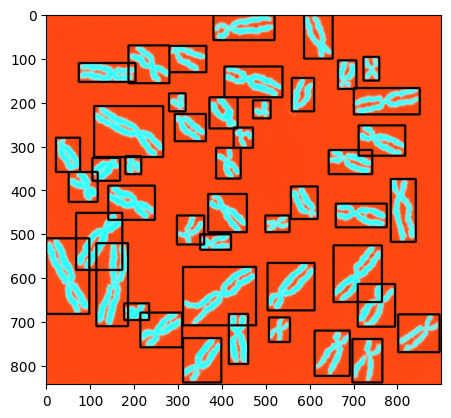

In [ ]:
# ----- Print Boxes ----- #

# Draw bounding boxes
out = image.copy() # Copy image

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(
        out,
        (x,y), # Coordinates
        (x+w, y +h), # Bounds
        (0, 0, 0), # Box colour (BGR)
        3 # Box thickness
    )

# Display 
plt.imshow(out)

In [ ]:
#  ----- Standardization ---- #

from sklearn.preprocessing import StandardScaler

feature_coloums : list = [
    'width', 'height', 'aspect_ratio', 'area', 'perimeter', 'circularity'
]

scaler = StandardScaler() # Define scaler
df_standard = df.copy()
df_standard[feature_coloums] = scaler.fit_transform(df_standard[feature_coloums])

print(df_standard)



    id    x    y      area  perimeter  circularity     width    height  \
0    0  696  739 -0.299402   0.530183    -1.170675 -0.403718  0.538851   
1    1  311  737  0.402025   0.329132    -0.421609  0.166314  0.596162   
2    2  610  720 -0.069203   0.710838    -1.159382 -0.043698  0.653473   
3    3  506  690 -1.225441  -0.935169    -0.266451 -1.003752 -0.693342   
4    4  800  683 -0.229539   0.740678    -1.281314  0.376325  0.166327   
5    5  415  682  0.529177   0.215451    -0.141518 -1.123758  0.968686   
6    6  214  679  0.249374  -0.186523     0.366833  0.406327 -0.034262   
7    7  177  658 -1.037858  -1.164576     1.193802 -0.733737 -1.209144   
8    8  708  614  0.504725   0.004701     0.226776  0.106310  0.481540   
9    9  311  575  2.106341   1.493649    -0.708135  2.536446  1.513143   
10  10  503  566  1.030446   0.132841     0.470762  0.766347  0.796752   
11  11  653  526  0.935083   1.941587    -1.418407  0.856352  1.398520   
12  12  114  521  2.327110   1.951669 

In [ ]:
# ---- Normalization ---- #

from sklearn.preprocessing import MinMaxScaler

feature_coloums : list = [
    'width', 'height', 'aspect_ratio', 'area', 'perimeter', 'circularity'
]

normalizer = MinMaxScaler() # Define scaler (normal)
df_normal = df.copy()

df_normal[feature_coloums] = normalizer.fit_transform(df_normal[feature_coloums])
print(df_normal)


    id    x    y      area  perimeter  circularity     width    height  \
0    0  696  739  0.301372   0.557103     0.104325  0.246154  0.415584   
1    1  311  737  0.483868   0.502842     0.303521  0.392308  0.428571   
2    2  610  720  0.361265   0.605859     0.107328  0.338462  0.441558   
3    3  506  690  0.060438   0.161628     0.344781  0.092308  0.136364   
4    4  800  683  0.319549   0.613912     0.074904  0.446154  0.331169   
5    5  415  682  0.516950   0.472162     0.378004  0.061538  0.512987   
6    6  214  679  0.444152   0.363675     0.513188  0.453846  0.285714   
7    7  177  658  0.109243   0.099715     0.733099  0.161538  0.019481   
8    8  708  614  0.510588   0.415284     0.475943  0.376923  0.402597   
9    9  311  575  0.927293   0.817127     0.227326  1.000000  0.636364   
10  10  503  566  0.647369   0.449867     0.540825  0.546154  0.474026   
11  11  653  526  0.622557   0.938018     0.038447  0.569231  0.610390   
12  12  114  521  0.984731   0.940739 

# Report

### Question 1
Contour detection can be used to find objects in an image. It does this by tracing the boundaries. Here, this is done on a thresholded image to eliminate noise. Each detected body is returned as a contour.

### Question 2
Standardization of data is useful for ML methods to ensure all data is weighted equally. Most ML algorithms are sensitive to feature scaling. Standardization ensures all continuous features exist within the same scale. Otherwise features with larger scales will dominate the ML model.

### Question 3
There are multiple ways in which one may handle a missing value in a dataset.

* One may extrapolate the missing value using linear regression against a correlated feature.
* One may interpolate the missing value from the rest of the filled data.
* Mean imputation may be used to fill in missing values.
* The datapoint with the missing value may be dropped.
* If  most of the datapoints in the coloumn (feature) are missing, the feature may be dropped in its entirety.

### Question 4

Normalization allows features to be scaled to a bound range, usually between 0 and 1. This allows all features to live in the same range, equalising the contribution of each feature in scale sensitive ML algorithms. Normalization removes dimensionality from features.

### Question 5

We may seperate overlapping chromosomes by applying morphological operatons (such as erosion) to break thin connections. One may also use rotated boxes instead of axis-aligned boxes. Merged contours may be split using shape cues.


